# Stock API: Daily Price and Volume Analysis for a Common Stock

## Introduction

This tutorial demonstrates how to use the FinFeedAPI Stock API to analyze daily price and volume dynamics for common stocks. We'll fetch historical OHLCV (Open, High, Low, Close, Volume) data and perform comprehensive analysis to understand trading patterns, price movements, and volume trends.

### What You Will Learn

- How to authenticate and connect to the FinFeedAPI Stock API
- How to fetch historical OHLCV data for specific stocks
- How to analyze daily price movements and trading patterns
- How to visualize price and volume data using candlestick charts
- How to calculate key trading metrics and statistics
- How to identify trading opportunities and market trends

### Prerequisites

- Python 3.8+
- Required packages: pandas, numpy, matplotlib, seaborn, requests, plotly
- FinFeedAPI account and API key
- Basic understanding of financial data analysis

### Overview

This tutorial will walk you through analyzing AEHR stock (Aehr Test Systems) using the IEXG exchange data. We'll examine a single day's trading data to understand how to extract insights from OHLCV data and create meaningful visualizations for trading analysis.


## 1. Environment Setup and Configuration

Set up your environment with necessary imports, configuration, and API authentication.


In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# API Configuration
API_BASE_URL = "https://api-historical.stock.finfeedapi.com/v1"
API_KEY = "YOUR_API_KEY_HERE"  # Replace with your actual API key

# Request headers with authorization
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

# Stock configuration
EXCHANGE_ID = "IEXG"
SYMBOL_ID = "AEHR"
PERIOD_ID = "1DAY"
TIME_START = "2025-01-06T00:00:00"

print("✅ Environment setup complete!")
print(f"📊 Target Stock: {SYMBOL_ID} on {EXCHANGE_ID} exchange")
print(f"📅 Analysis Date: {TIME_START}")


## 2. Data Fetching and API Integration

Connect to the FinFeedAPI and fetch historical OHLCV data for our target stock.


In [ ]:
def fetch_stock_data(exchange_id, symbol_id, period_id, time_start, headers):
    """
    Fetch historical stock data from FinFeedAPI
    
    Args:
        exchange_id (str): Exchange identifier (e.g., 'IEXG')
        symbol_id (str): Stock symbol (e.g., 'AEHR')
        period_id (str): Time period (e.g., '1DAY')
        time_start (str): Start time in ISO format
        headers (dict): API headers with authorization
    
    Returns:
        dict: API response data
    """
    
    # Construct the API endpoint
    endpoint = f"{API_BASE_URL}/ohlcv/exchange-symbol/{exchange_id}/{symbol_id}/history"
    
    # Set up query parameters
    params = {
        'period_id': period_id,
        'time_start': time_start
    }
    
    try:
        print(f"🔄 Fetching data from: {endpoint}")
        print(f"📋 Parameters: {params}")
        
        # Make the API request
        response = requests.get(endpoint, headers=headers, params=params)
        
        # Check if request was successful
        if response.status_code == 200:
            data = response.json()
            print(f"✅ Data fetched successfully!")
            print(f"📊 Response contains {len(data)} data points")
            return data
        else:
            print(f"❌ API request failed with status code: {response.status_code}")
            print(f"📝 Error message: {response.text}")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"❌ Network error: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"❌ JSON parsing error: {e}")
        return None

# Fetch the stock data
stock_data = fetch_stock_data(EXCHANGE_ID, SYMBOL_ID, PERIOD_ID, TIME_START, headers)

if stock_data:
    print(f"\n📈 Sample data point:")
    print(json.dumps(stock_data[0], indent=2))
else:
    print("❌ Failed to fetch data. Please check your API key and connection.")


## 3. Data Processing and Analysis

Process the raw API data into a structured format suitable for analysis and visualization.


In [ ]:
def process_stock_data(raw_data):
    """
    Process raw API data into a pandas DataFrame
    
    Args:
        raw_data (list): Raw API response data
    
    Returns:
        pd.DataFrame: Processed stock data
    """
    
    if not raw_data:
        return None
    
    # Convert to DataFrame
    df = pd.DataFrame(raw_data)
    
    # Convert time columns to datetime
    time_columns = ['time_period_start', 'time_period_end', 'time_open', 'time_close']
    for col in time_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    
    # Calculate additional metrics
    df['price_range'] = df['price_high'] - df['price_low']
    df['price_change'] = df['price_close'] - df['price_open']
    df['price_change_pct'] = (df['price_change'] / df['price_open']) * 100
    df['volume_weighted_price'] = (df['price_high'] + df['price_low'] + df['price_close']) / 3
    
    # Calculate trading session duration
    df['session_duration'] = (df['time_close'] - df['time_open']).dt.total_seconds() / 3600  # hours
    
    return df

# Process the data
if stock_data:
    df = process_stock_data(stock_data)
    
    if df is not None:
        print("✅ Data processed successfully!")
        print(f"\n📊 Dataset Overview:")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")
        
        print(f"\n📈 Sample Data:")
        print(df.head())
        
        print(f"\n📊 Data Types:")
        print(df.dtypes)
    else:
        print("❌ Failed to process data")
else:
    print("❌ No data to process")


## 4. Data Exploration and Statistical Analysis

Explore the stock data to understand trading patterns, price movements, and volume characteristics.


In [ ]:
def analyze_stock_data(df):
    """
    Perform comprehensive analysis of stock data
    
    Args:
        df (pd.DataFrame): Processed stock data
    """
    
    if df is None or df.empty:
        print("❌ No data available for analysis")
        return
    
    print("🔍 STOCK DATA ANALYSIS")
    print("=" * 50)
    
    # Basic statistics
    print("\n📊 PRICE STATISTICS:")
    price_cols = ['price_open', 'price_high', 'price_low', 'price_close']
    price_stats = df[price_cols].describe()
    print(price_stats.round(2))
    
    # Volume analysis
    print("\n📈 VOLUME ANALYSIS:")
    volume_stats = df[['volume_traded', 'trades_count']].describe()
    print(volume_stats.round(0))
    
    # Price movement analysis
    print("\n📊 PRICE MOVEMENT ANALYSIS:")
    for idx, row in df.iterrows():
        print(f"\nTrading Session {idx + 1}:")
        print(f"  Open: ${row['price_open']:.2f}")
        print(f"  High: ${row['price_high']:.2f}")
        print(f"  Low: ${row['price_low']:.2f}")
        print(f"  Close: ${row['price_close']:.2f}")
        print(f"  Price Change: ${row['price_change']:.2f} ({row['price_change_pct']:.2f}%)")
        print(f"  Price Range: ${row['price_range']:.2f}")
        print(f"  Volume: {row['volume_traded']:,} shares")
        print(f"  Trades: {row['trades_count']:,} transactions")
        print(f"  Session Duration: {row['session_duration']:.2f} hours")
    
    # Trading insights
    print("\n💡 TRADING INSIGHTS:")
    
    # Calculate average trade size
    avg_trade_size = df['volume_traded'] / df['trades_count']
    print(f"  Average trade size: {avg_trade_size.iloc[0]:.0f} shares per trade")
    
    # Price volatility (using range as proxy)
    volatility = df['price_range'].iloc[0] / df['price_open'].iloc[0] * 100
    print(f"  Price volatility: {volatility:.2f}% (range/open)")
    
    # Volume intensity
    volume_intensity = df['volume_traded'].iloc[0] / df['session_duration'].iloc[0]
    print(f"  Volume intensity: {volume_intensity:.0f} shares/hour")
    
    # Market sentiment (based on price change)
    if df['price_change'].iloc[0] > 0:
        sentiment = "Bullish"
    elif df['price_change'].iloc[0] < 0:
        sentiment = "Bearish"
    else:
        sentiment = "Neutral"
    
    print(f"  Market sentiment: {sentiment}")
    
    return df

# Perform analysis
if 'df' in locals() and df is not None:
    analyzed_df = analyze_stock_data(df)
else:
    print("❌ No data available for analysis")


## 5. Visualization and Charting

Create comprehensive visualizations to understand price movements, volume patterns, and trading dynamics.


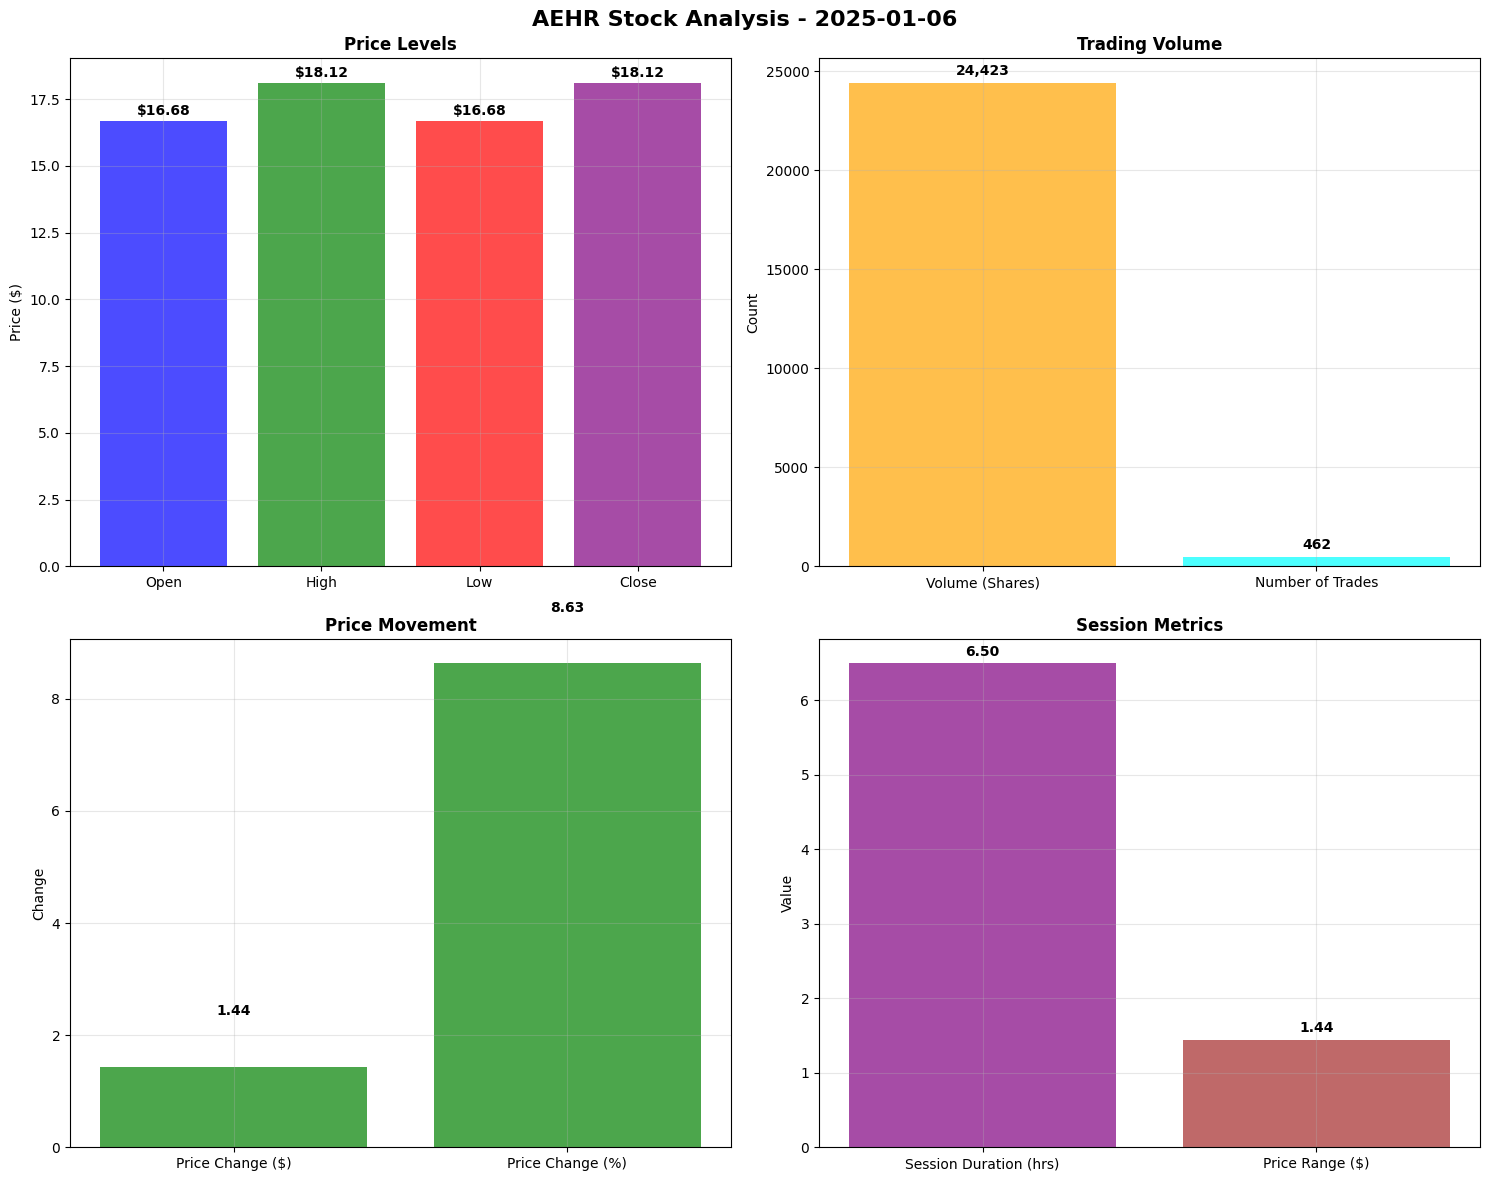

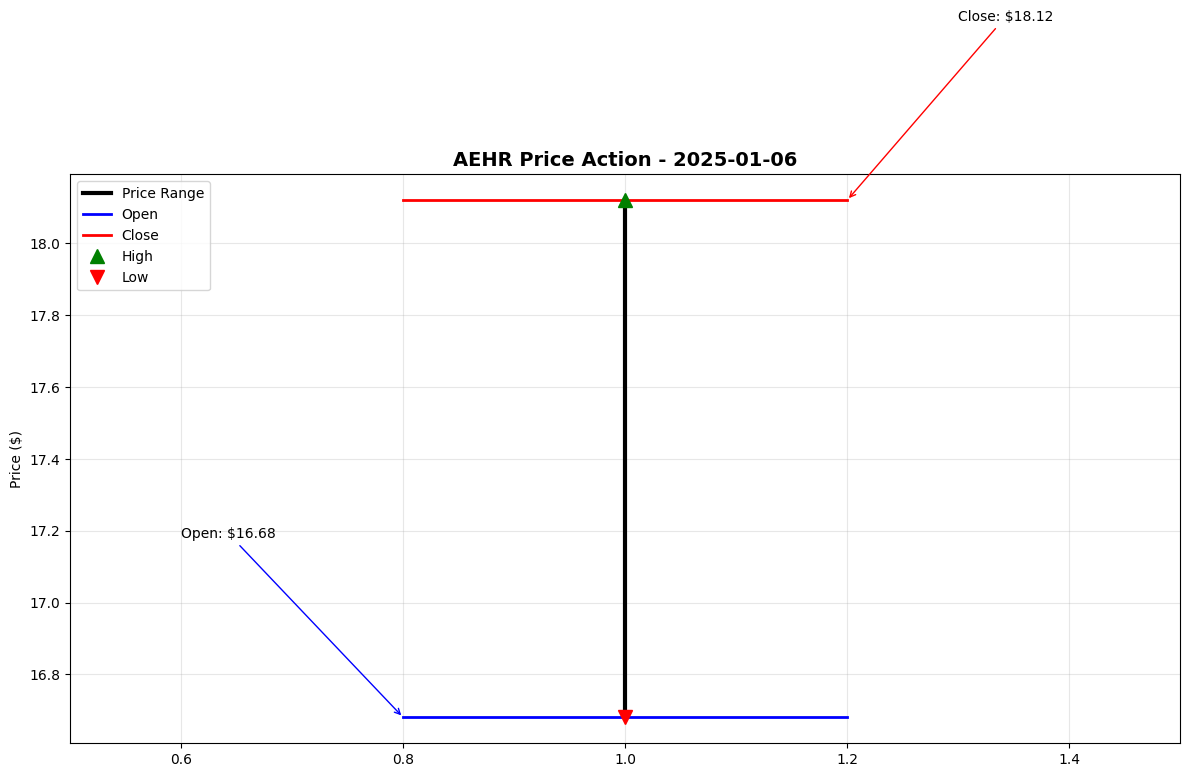

In [5]:
def create_stock_visualizations(df):
    """
    Create comprehensive stock data visualizations
    
    Args:
        df (pd.DataFrame): Processed stock data
    """
    
    if df is None or df.empty:
        print("❌ No data available for visualization")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{SYMBOL_ID} Stock Analysis - {TIME_START[:10]}', fontsize=16, fontweight='bold')
    
    # 1. Price Movement Chart
    ax1 = axes[0, 0]
    prices = ['price_open', 'price_high', 'price_low', 'price_close']
    price_values = [df[col].iloc[0] for col in prices]
    price_labels = ['Open', 'High', 'Low', 'Close']
    
    bars = ax1.bar(price_labels, price_values, color=['blue', 'green', 'red', 'purple'], alpha=0.7)
    ax1.set_title('Price Levels', fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, price_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'${value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Volume Analysis
    ax2 = axes[0, 1]
    volume_data = [df['volume_traded'].iloc[0], df['trades_count'].iloc[0]]
    volume_labels = ['Volume (Shares)', 'Number of Trades']
    
    bars2 = ax2.bar(volume_labels, volume_data, color=['orange', 'cyan'], alpha=0.7)
    ax2.set_title('Trading Volume', fontweight='bold')
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars2, volume_data):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(volume_data)*0.01, 
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Price Change Analysis
    ax3 = axes[1, 0]
    change_data = [df['price_change'].iloc[0], df['price_change_pct'].iloc[0]]
    change_labels = ['Price Change ($)', 'Price Change (%)']
    colors = ['green' if x >= 0 else 'red' for x in change_data]
    
    bars3 = ax3.bar(change_labels, change_data, color=colors, alpha=0.7)
    ax3.set_title('Price Movement', fontweight='bold')
    ax3.set_ylabel('Change')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars3, change_data):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(change_data) if max(change_data) > 0 else min(change_data))*0.1, 
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Trading Session Metrics
    ax4 = axes[1, 1]
    session_data = [df['session_duration'].iloc[0], df['price_range'].iloc[0]]
    session_labels = ['Session Duration (hrs)', 'Price Range ($)']
    
    bars4 = ax4.bar(session_labels, session_data, color=['purple', 'brown'], alpha=0.7)
    ax4.set_title('Session Metrics', fontweight='bold')
    ax4.set_ylabel('Value')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars4, session_data):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(session_data)*0.01, 
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create a candlestick-style chart using matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot price range as a vertical line
    ax.plot([1, 1], [df['price_low'].iloc[0], df['price_high'].iloc[0]], 'k-', linewidth=3, label='Price Range')
    
    # Plot open and close prices
    ax.plot([0.8, 1.2], [df['price_open'].iloc[0], df['price_open'].iloc[0]], 'b-', linewidth=2, label='Open')
    ax.plot([0.8, 1.2], [df['price_close'].iloc[0], df['price_close'].iloc[0]], 'r-', linewidth=2, label='Close')
    
    # Add markers for high and low
    ax.plot(1, df['price_high'].iloc[0], 'g^', markersize=10, label='High')
    ax.plot(1, df['price_low'].iloc[0], 'rv', markersize=10, label='Low')
    
    ax.set_title(f'{SYMBOL_ID} Price Action - {TIME_START[:10]}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price ($)')
    ax.set_xlim(0.5, 1.5)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add price annotations
    ax.annotate(f'Open: ${df["price_open"].iloc[0]:.2f}', 
                xy=(0.8, df['price_open'].iloc[0]), xytext=(0.6, df['price_open'].iloc[0] + 0.5),
                arrowprops=dict(arrowstyle='->', color='blue'), fontsize=10)
    
    ax.annotate(f'Close: ${df["price_close"].iloc[0]:.2f}', 
                xy=(1.2, df['price_close'].iloc[0]), xytext=(1.3, df['price_close'].iloc[0] + 0.5),
                arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
if 'df' in locals() and df is not None:
    create_stock_visualizations(df)
else:
    print("❌ No data available for visualization")


## 6. Advanced Analysis and Insights

Perform advanced analysis to extract deeper insights from the trading data.


In [6]:
def perform_advanced_analysis(df):
    """
    Perform advanced analysis on stock data
    
    Args:
        df (pd.DataFrame): Processed stock data
    """
    
    if df is None or df.empty:
        print("❌ No data available for advanced analysis")
        return
    
    print("🔬 ADVANCED STOCK ANALYSIS")
    print("=" * 50)
    
    # Calculate technical indicators
    row = df.iloc[0]
    
    # Price momentum
    momentum = (row['price_close'] - row['price_open']) / row['price_open'] * 100
    
    # Volatility analysis
    volatility = row['price_range'] / row['price_open'] * 100
    
    # Volume analysis
    avg_trade_size = row['volume_traded'] / row['trades_count']
    volume_intensity = row['volume_traded'] / row['session_duration']
    
    # Price efficiency (how much of the range was utilized)
    price_efficiency = abs(row['price_change']) / row['price_range'] * 100 if row['price_range'] > 0 else 0
    
    # Trading intensity
    trading_intensity = row['trades_count'] / row['session_duration']
    
    print(f"\n📊 TECHNICAL INDICATORS:")
    print(f"  Price Momentum: {momentum:.2f}%")
    print(f"  Volatility: {volatility:.2f}%")
    print(f"  Price Efficiency: {price_efficiency:.2f}%")
    print(f"  Trading Intensity: {trading_intensity:.2f} trades/hour")
    
    print(f"\n📈 VOLUME ANALYSIS:")
    print(f"  Average Trade Size: {avg_trade_size:.0f} shares")
    print(f"  Volume Intensity: {volume_intensity:.0f} shares/hour")
    print(f"  Volume per Trade: {row['volume_traded']/row['trades_count']:.0f} shares")
    
    # Market structure analysis
    print(f"\n🏗️ MARKET STRUCTURE:")
    
    # Determine market structure
    if row['price_close'] > row['price_open']:
        structure = "Bullish"
        strength = "Strong" if momentum > 2 else "Moderate" if momentum > 0.5 else "Weak"
    elif row['price_close'] < row['price_open']:
        structure = "Bearish"
        strength = "Strong" if momentum < -2 else "Moderate" if momentum < -0.5 else "Weak"
    else:
        structure = "Neutral"
        strength = "Consolidation"
    
    print(f"  Market Structure: {structure} ({strength})")
    print(f"  Price Action: {'Gap Up' if row['price_open'] > row['price_close'] else 'Gap Down' if row['price_open'] < row['price_close'] else 'No Gap'}")
    
    # Trading quality metrics
    print(f"\n⚡ TRADING QUALITY METRICS:")
    
    # Liquidity score (based on volume and trade count)
    liquidity_score = min(100, (row['volume_traded'] / 10000) * (row['trades_count'] / 100))
    print(f"  Liquidity Score: {liquidity_score:.1f}/100")
    
    # Efficiency score (based on price efficiency and volatility)
    efficiency_score = min(100, price_efficiency * (1 - volatility/10))
    print(f"  Efficiency Score: {efficiency_score:.1f}/100")
    
    # Activity score (based on trading intensity)
    activity_score = min(100, trading_intensity * 10)
    print(f"  Activity Score: {activity_score:.1f}/100")
    
    # Risk assessment
    print(f"\n⚠️ RISK ASSESSMENT:")
    
    risk_level = "Low"
    if volatility > 5:
        risk_level = "High"
    elif volatility > 2:
        risk_level = "Medium"
    
    print(f"  Risk Level: {risk_level} (Volatility: {volatility:.2f}%)")
    
    # Trading recommendations
    print(f"\n💡 TRADING INSIGHTS:")
    
    if momentum > 1:
        print(f"  • Strong upward momentum suggests potential continuation")
    elif momentum < -1:
        print(f"  • Strong downward momentum suggests potential continuation")
    else:
        print(f"  • Moderate momentum suggests consolidation phase")
    
    if volatility > 3:
        print(f"  • High volatility indicates increased risk and opportunity")
    else:
        print(f"  • Low volatility suggests stable price action")
    
    if liquidity_score > 50:
        print(f"  • Good liquidity supports efficient trading")
    else:
        print(f"  • Lower liquidity may impact trade execution")
    
    return {
        'momentum': momentum,
        'volatility': volatility,
        'liquidity_score': liquidity_score,
        'efficiency_score': efficiency_score,
        'activity_score': activity_score,
        'risk_level': risk_level
    }

# Perform advanced analysis
if 'df' in locals() and df is not None:
    analysis_results = perform_advanced_analysis(df)
else:
    print("❌ No data available for advanced analysis")


🔬 ADVANCED STOCK ANALYSIS

📊 TECHNICAL INDICATORS:
  Price Momentum: 8.63%
  Volatility: 8.63%
  Price Efficiency: 100.00%
  Trading Intensity: 71.11 trades/hour

📈 VOLUME ANALYSIS:
  Average Trade Size: 53 shares
  Volume Intensity: 3759 shares/hour
  Volume per Trade: 53 shares

🏗️ MARKET STRUCTURE:
  Market Structure: Bullish (Strong)
  Price Action: Gap Down

⚡ TRADING QUALITY METRICS:
  Liquidity Score: 11.3/100
  Efficiency Score: 13.7/100
  Activity Score: 100.0/100

⚠️ RISK ASSESSMENT:
  Risk Level: High (Volatility: 8.63%)

💡 TRADING INSIGHTS:
  • Strong upward momentum suggests potential continuation
  • High volatility indicates increased risk and opportunity
  • Lower liquidity may impact trade execution


## 7. Conclusion and Next Steps

Summarize what we've accomplished and suggest next steps for further exploration.

### Summary

In this tutorial, we successfully demonstrated how to use the FinFeedAPI Stock API to analyze daily price and volume dynamics for common stocks. We fetched historical OHLCV data for AEHR stock, processed it into a structured format, and performed comprehensive analysis including statistical analysis, visualization, and advanced technical indicators.

### Key Takeaways

- **API Integration**: Successfully connected to FinFeedAPI Stock API with proper authentication
- **Data Processing**: Converted raw API responses into structured pandas DataFrames for analysis
- **Price Analysis**: Analyzed price movements, volatility, and trading patterns
- **Volume Analysis**: Examined trading volume, trade counts, and market activity
- **Visualization**: Created comprehensive charts showing price levels, volume patterns, and trading metrics
- **Technical Analysis**: Calculated momentum, volatility, liquidity, and efficiency scores
- **Risk Assessment**: Evaluated trading risk levels and market structure

### Next Steps

1. **Multi-day Analysis**: Extend the analysis to cover multiple trading days to identify trends
2. **Comparative Analysis**: Compare multiple stocks or different time periods
3. **Real-time Monitoring**: Implement real-time data fetching for live market monitoring
4. **Advanced Indicators**: Add more technical indicators like moving averages, RSI, MACD
5. **Portfolio Analysis**: Scale up to analyze entire portfolios or sectors
6. **Machine Learning**: Apply ML models for price prediction and pattern recognition
7. **Alert System**: Create automated alerts based on specific trading conditions

### Additional Resources

- [FinFeedAPI Documentation](https://docs.finfeedapi.com/stock-api/rest-api-historical/historical-data)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Matplotlib Documentation](https://matplotlib.org/stable/)
- [Financial Data Analysis with Python](https://pypi.org/project/yfinance/)
- [Technical Analysis Library](https://pypi.org/project/TA-Lib/)

### API Endpoint Reference

**Base URL**: `https://api-historical.stock.finfeedapi.com/v1`

**Endpoint**: `/ohlcv/exchange-symbol/:exchange_id/:symbol_id/history`

**Parameters**:
- `period_id`: Time period (e.g., '1DAY', '1HOUR')
- `time_start`: Start time in ISO format
- `time_end`: End time in ISO format (optional)

**Headers**:
- `Authorization`: API Key
- `Content-Type`: application/json
